In [1]:
# 導入所需套件
import os
import cv2
import numpy as np
import pandas as pd
import random as rn
import tensorflow as tf
import keras
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Input, Dense, BatchNormalization, Activation, Flatten
from keras.optimizers import Nadam
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 設定隨機種子
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

# 設定介面與字型
plt.style.use('ggplot')
## 正常顯示中文為標楷體
plt.rcParams['font.family'] = 'DFKai-SB'
## 用來正常顯示負號
plt.rcParams['axes.unicode_minus'] = False

In [7]:
# 資料生成函數
def make_data(directory_names, imagesize):
    image_of_data = []
    label_of_data = []
    test_id = []
    # 讀取資料夾下所有影像
    for i, directory_name in enumerate(directory_names):
        for filename in os.listdir(r'data/' + directory_name + '/'):
            img = cv2.imread(r'data/' + directory_name + '/' + filename)
            img = cv2.resize(img, (imagesize, imagesize))
            image_of_data.append(np.array(img))
            if directory_name == 'test':
                test_id.append(filename[:-4])
            else:
                label_of_data.append(i)
    image_of_data = np.array(image_of_data)
    label_of_data = np.array(label_of_data)

    return image_of_data, test_id if directory_name == 'test' else label_of_data
        
# 設定參數
train_directory_names = ['image_data/train/daisy', 'image_data/train/dandelion', 'image_data/train/rose', 'image_data/train/sunflower', 'image_data/train/tulip']
test_directory_names = ['image_data/test']
imagesize = 224

# 套用函數
x_train, y_train = make_data(train_directory_names, imagesize)
x_test, test_id = make_data(test_directory_names, imagesize)

x_train = x_train / 255.
x_test = x_test / 255.
y_train = to_categorical(y_train, 5)

# 輸出資料型態
print('shape of x_train', x_train.shape)
print('shape of y_train', y_train.shape)
print('shape of x_test', x_test.shape)

shape of x_train (2823, 224, 224, 3)
shape of y_train (2823, 5)
shape of x_test (2000, 224, 224, 3)


In [8]:
# 從train資料中分出val資料
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
print('shape of x_train', x_train.shape)
print('shape of y_train', y_train.shape)
print('shape of x_val', x_val.shape)
print('shape of y_val', y_val.shape)

shape of x_train (2258, 224, 224, 3)
shape of y_train (2258, 5)
shape of x_val (565, 224, 224, 3)
shape of y_val (565, 5)


In [9]:
# Parameters
batch_size = 10
epochs = 100

# callbacks
earlystop = EarlyStopping(monitor='val_accuracy', patience=15, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.8, min_lr=1e-12, monitor='val_accuracy', patience=3, verbose=1)
callbacks = [earlystop, reduce_lr]

In [10]:
datagen = ImageDataGenerator(rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
                             zoom_range=0.1, # Randomly zoom image 
                             width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
                             height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
                             horizontal_flip=True)  # randomly flip images
        
datagen.fit(x_train)ㄡ

In [11]:
# Build training model
inceptionv3 = InceptionV3(include_top=False, input_shape=(imagesize, imagesize, 3)) 
x = inceptionv3.output
x = GlobalAveragePooling2D()(x)

# 添加一個全連接層
x = Dense(512, activation='relu')(x)

# 添加一個分類器
output = Dense(5, activation='softmax')(x)
model = Model(inputs=inceptionv3.input, outputs=output)

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=Nadam(),
              metrics=['accuracy'])

history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, 
                              steps_per_epoch=x_train.shape[0] // batch_size, 
                              validation_data=(x_val,y_val),
                              verbose=1, 
                              callbacks=callbacks)

score = model.evaluate(x_val, y_val, verbose=0)
print('val loss:', score[0])
print('val accuracy:', score[1])

87916544/87910968 [==============================] - 9s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________

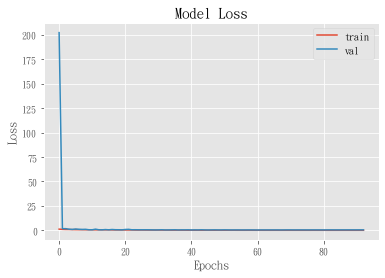

In [12]:
# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

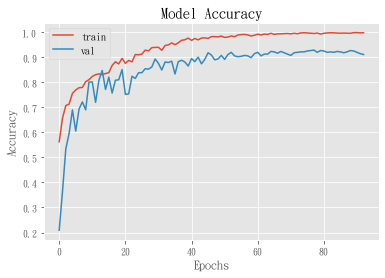

In [13]:
# plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

In [14]:
# predict
pred = model.predict(x_test)
flower_class = np.argmax(pred, axis=1)

# 轉為DataFrame並儲存
df_pred = pd.DataFrame(flower_class)
df_pred.columns = ['flower_class']
df_pred['id'] = test_id
df_pred = df_pred[['id', 'flower_class']]
df_pred.to_csv('Submission_datagen_10_0.2_inceptionv3_val_acc.csv', index=False)